In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


torch.manual_seed(1)
logging.basicConfig(level=logging.DEBUG, format='%(name)s - %(levelname)s - %(message)s')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

matplotlib.backends - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def __load_data_file(self):
    data = pd.read_csv(self.FILENAME)
    data["emotion"] = data["Field1"]
    data["text"] = data["SIT"]
    return data[["text", "emotion"]]

  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_file()
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

In [3]:
isear_dataset = ISEARDataset()
train_data, test_data = isear_dataset.load_data()
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

logging.debug("train_data.shape: (%d, %d)" % train_data.shape)
logging.debug("valid_data.shape: (%d, %d)" % valid_data.shape)
logging.debug("test_data.shape: (%d, %d)" % test_data.shape)

root - DEBUG - train_data.shape: (4829, 2)
root - DEBUG - valid_data.shape: (537, 2)
root - DEBUG - test_data.shape: (2300, 2)


root - DEBUG - class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
root - DEBUG - class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
root - DEBUG - number of bins: 7
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


bins: [0, 1, 2, 3, 4, 5, 6, 7]


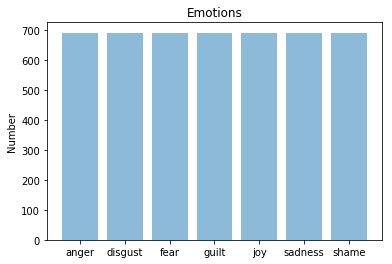

In [4]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
n_classes = len(labels)
logging.debug("class dictionary: %s" % dic)
logging.debug("class labels: %s" % labels)
logging.debug("number of bins: %s" % n_classes)

for emotion in labels:
  train_data.loc[train_data.emotion == emotion, "emotion_int"] = dic[emotion]
  valid_data.loc[valid_data.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]

bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(train_data["emotion_int"], bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [36]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0)

allennlp.modules.elmo - INFO - Initializing ELMo
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5 HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5 HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west

In [81]:
from allennlp.commands.elmo import ElmoEmbedder


options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

elmo = ElmoEmbedder(options_file, weight_file, cuda_device=0)

allennlp.commands.elmo - INFO - Initializing ELMo.
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5 HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com:443
urllib3.connectionpool - DEBUG - https://s3-us-west-2.amazonaws.com:443 "HEAD /allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5 HTTP/1.1" 200 0
urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3-us-we

In [82]:
vector = elmo.embed_sentence(["Hello", "I", "love", "you"])
vector

array([[[ 0.07195003, -0.23072985, -0.00943072, ..., -0.6438828 ,
         -0.6441163 , -0.24662834],
        [-0.21027166, -0.2679156 , -0.15733792, ..., -0.18545806,
          0.22321805,  0.07739294],
        [-0.86810684,  0.6293375 ,  0.22367026, ..., -0.09220622,
          1.0322137 , -0.5260475 ],
        [-0.11161093,  0.4175899 ,  0.39825487, ...,  0.39508057,
          0.0679122 ,  0.03724104]],

       [[ 0.03155486, -0.17761199, -0.7605889 , ...,  0.41598114,
          0.10596061, -0.24359159],
        [ 0.33438826, -0.9164163 ,  0.1910559 , ..., -0.15816395,
          0.09414726, -0.1000901 ],
        [-0.2522697 , -0.23032828, -0.4141932 , ...,  0.34381485,
          0.45502275, -0.02311403],
        [-0.16855855,  0.15430757, -0.18263504, ...,  0.60374373,
         -0.34326386, -0.11222638]],

       [[-0.97102267, -1.4836148 ,  0.98300326, ..., -0.57647145,
         -0.14606684, -1.2897296 ],
        [ 0.8983372 , -1.3780742 ,  0.15474083, ..., -0.5491963 ,
         -0.

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, elmo_embedding, input_dim, embedding_dim, 
                 hidden_dim, batch_size, output_dim=1, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.elmo = elmo_embedding
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, self.num_layers)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, sentence):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        embeds = self.elmo(sentence)['elmo_representations'][0]
        lstm_out, self.hidden = self.lstm(embeds.view(self.input_dim, self.batch_size, -1))
        flatten = self.linear(lstm_out[-1].view(self.batch_size, -1))
        output = self.sigmoid(flatten)
        return output

In [46]:
from keras.utils import to_categorical

device = torch.device('cuda:0')
input_dim = 280
embedding_dim = 256
hidden_dim = 256
batch_size = 10
output_dim = 6
elmo_cuda = elmo.to(device)
model = LSTMClassifier(elmo_cuda, input_dim, embedding_dim, hidden_dim, batch_size, output_dim)
# model = model.to(device)
X_train = batch_to_ids(train_data.text[0:10])
# X_train = X_train.to(device)
y_train = to_categorical(np.asarray(train_data.emotion[0:10].apply(lambda x:dic[x])))
# y_train = torch.from_numpy(y_train).to(device)
embeddings = model(X_train) 

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #3 'index'

In [45]:
loss_fn = nn.BCELoss()
num_epochs = 200
learning_rate = 1e-3
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)
    
    loss = loss_fn(y_pred, y_train)
    print("Epoch ", t, "Cross Entropy Loss: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #3 'index'